# Project 2
Michael Person

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
print('Import Complete')

Import Complete


---

## Step 1: Dataset Summary & Exploration

 

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# Number of validation examples.
n_validation = len(X_valid)

csv = np.genfromtxt ('signnames.csv', delimiter=",")
n_csv = len(csv)
signs = np.copy(csv[1:n_csv])
n_classes = len(signs)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

10


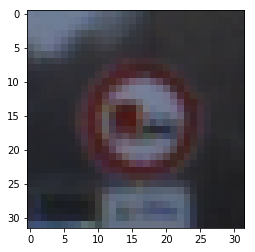

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure()
plt.imshow(image)
print(y_train[index])

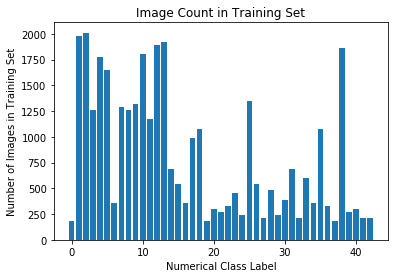

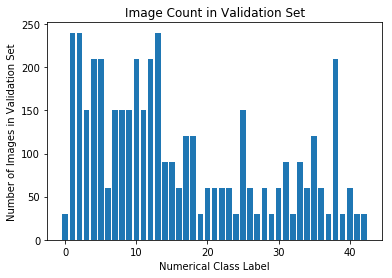

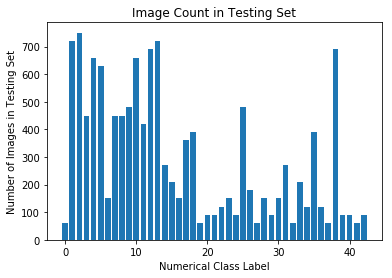

In [4]:
import plotly.plotly as py

training_numbers = []
valid_numbers = []
testing_numbers = []
numbers = range(n_classes)
for i in range(n_classes):
    x_train = np.argwhere(y_train==i)
    x_valid = np.argwhere(y_valid==i)
    x_test = np.argwhere(y_test==i)
    training_numbers.append(len(x_train))
    valid_numbers.append(len(x_valid))
    testing_numbers.append(len(x_test))

plt.figure()
plt.bar(numbers,training_numbers)
plt.xlabel('Numerical Class Label')
plt.ylabel('Number of Images in Training Set')
plt.title('Image Count in Training Set')

plt.figure()
plt.bar(numbers,valid_numbers)
plt.xlabel('Numerical Class Label')
plt.ylabel('Number of Images in Validation Set')
plt.title('Image Count in Validation Set')

plt.figure()
plt.bar(numbers,testing_numbers)
plt.xlabel('Numerical Class Label')
plt.ylabel('Number of Images in Testing Set')
plt.title('Image Count in Testing Set')

# Data Augmentation

In [5]:
import cv2

# Translate the pictures
x_translated = []
y_translated = np.copy(y_train)

for i in range(n_train):
    ind = (np.random.rand(2)*20)-10
    M_translate = np.float32([[1,0,ind[0]],[0,1,ind[1]]])
    x_translated.append(cv2.warpAffine(X_train[i],M_translate,(32,32)))

In [6]:
# Rotate the pictures
x_rotated = []
y_rotated = np.copy(y_train)

for i in range(n_train):
    ind = (np.random.rand(1)*90)-45
    M = cv2.getRotationMatrix2D((32/2,32/2),ind[0],1)
    x_rotated.append(cv2.warpAffine(X_train[i],M,(32,32)))

In [7]:
# Flip the pictures
x_flipped = []
y_flipped = np.copy(y_train)

for i in range(n_train):
    x_flipped.append(np.fliplr(X_train[i]))

In [8]:
# Rotate the Translated pictures
x_rotated_translated = []
y_rotated_translated = np.copy(y_train)

for i in range(n_train):
    ind = (np.random.rand(1)*90)-45
    M = cv2.getRotationMatrix2D((32/2,32/2),ind[0],1)
    x_rotated_translated.append(cv2.warpAffine(x_translated[i],M,(32,32)))

In [9]:
# Color Shifted pictures
x_colored = []
y_colored = np.copy(y_train)


for z in range(n_train):
    R = np.ndarray.flatten(X_train[z,:,:,0])
    G = np.ndarray.flatten(X_train[z,:,:,1])
    B = np.ndarray.flatten(X_train[z,:,:,2])
    vector_img = np.array((R,G,B))
    corr_mat = np.corrcoef(vector_img)
    w, v = np.linalg.eig(corr_mat)
    
    new_img = np.copy(X_train[0])*0

    s = 1

    for i in range(32):
        for j in range(32):
            rand = np.array((np.random.normal(loc=0,scale=s),np.random.normal(loc=0,scale=s),np.random.normal(loc=0,scale=s)))
            temp = np.dot(v,w*rand)
            new_img[i,j,:] = temp+X_train[z,i,j,:]
    x_colored.append(new_img) 

In [10]:
# Add them to the training array
X_augmented_train = np.concatenate((X_train,x_translated,x_rotated,x_rotated_translated,x_colored))
y_augmented_train = np.concatenate((y_train,y_translated,y_rotated,y_rotated_translated,y_colored))

n_augmented_train = len(X_augmented_train)
print(n_augmented_train)

173995


Shuffle it.

In [11]:
from sklearn.utils import shuffle

X_augmented_train, y_augmented_train = shuffle(X_augmented_train, y_augmented_train)

----

## Step 2: Design and Test a Model Architecture


### Model Architecture

In [37]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 256

from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID') + b
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def activation(x):
    return tf.nn.relu(x)

mu = 0
sigma = 0.1

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
# Define weight and bias terms for every layer
weights = {
    # Convolutional Layer 1, Input: 32x32x3    Output: 28x28x6
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)),
    # Convolutional Layer 2, Input: 14x14x6     Output: 10x10x16
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    # Pooling Layer 1, Input: 400     Output: 120
    'wd1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
    # Pooling Layer 2, Input: 120     Output: 84
    'wd2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
    # Pooling Layer 3, Input: 84     Output: 10
    'wd3': tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))}

biases = {
    # Convolutional Layer 1, Input: 32x32x3    Output: 28x28x6
    'bc1': tf.Variable(tf.zeros(6)),
    # Convolutional Layer 2, Input: 14x14x6     Output: 10x10x16
    'bc2': tf.Variable(tf.zeros(16)),
    # Pooling Layer 1, Input: 400     Output: 120
    'bd1': tf.Variable(tf.zeros(120)),
    # Pooling Layer 2, Input: 120     Output: 84
    'bd2': tf.Variable(tf.zeros(84)),
    # Pooling Layer 3, Input: 84     Output: 10
    'bd3': tf.Variable(tf.zeros(43))}

def LeNet(x):    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1 = conv2d(x, weights['wc1'],biases['bc1'])
    
    # Local Response Normalization
    conv1 = tf.nn.local_response_normalization(conv1,5,2.0,0.001,0.75)

    # Activation.
    conv1 = activation(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'],biases['bc2'])
    
    # Local Response Normalization
    conv2 = tf.nn.local_response_normalization(conv2,5,2.0,0.001,0.75)
    
    # Activation.
    conv2 = activation(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    pool1 = tf.matmul(flat,weights['wd1']) + biases['bd1']
    
    # Activation.
    pool1 = activation(pool1)
    
    # Dropout
    pool1 = tf.nn.dropout(pool1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    pool2 = tf.matmul(pool1,weights['wd2']) + biases['bd2']
    
    # Activation.
    pool2 = activation(pool2)
    
    # Dropout
    pool2 = tf.nn.dropout(pool2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.matmul(pool2,weights['wd3']) + biases['bd3']
    
    return logits

### Train, Validate and Test the Model

In [38]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32) # probability to keep units

In [39]:
rate = 0.0001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [40]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [41]:
validation = []
training = []
t = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, n_augmented_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_augmented_train[offset:end], y_augmented_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:.5})
        
        # Evaluate the network
        validation_accuracy = evaluate(X_valid, y_valid)
        training_accuracy = evaluate(X_augmented_train, y_augmented_train)
        
        # Append values to graph later
        validation.append(validation_accuracy)
        training.append(training_accuracy)
        t.append(i)
        
        # Print training status
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.197
Training Accuracy = 0.170

EPOCH 2 ...
Validation Accuracy = 0.314
Training Accuracy = 0.259

EPOCH 3 ...
Validation Accuracy = 0.387
Training Accuracy = 0.308

EPOCH 4 ...
Validation Accuracy = 0.416
Training Accuracy = 0.337

EPOCH 5 ...
Validation Accuracy = 0.448
Training Accuracy = 0.363

EPOCH 6 ...
Validation Accuracy = 0.497
Training Accuracy = 0.389

EPOCH 7 ...
Validation Accuracy = 0.541
Training Accuracy = 0.417

EPOCH 8 ...
Validation Accuracy = 0.570
Training Accuracy = 0.444

EPOCH 9 ...
Validation Accuracy = 0.598
Training Accuracy = 0.470

EPOCH 10 ...
Validation Accuracy = 0.624
Training Accuracy = 0.494

EPOCH 11 ...
Validation Accuracy = 0.663
Training Accuracy = 0.516

EPOCH 12 ...
Validation Accuracy = 0.694
Training Accuracy = 0.536

EPOCH 13 ...
Validation Accuracy = 0.721
Training Accuracy = 0.555

EPOCH 14 ...
Validation Accuracy = 0.739
Training Accuracy = 0.567

EPOCH 15 ...
Validation Accuracy = 0.764
Tra

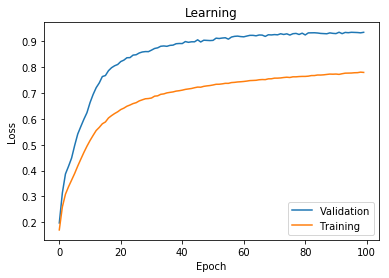

In [42]:
# Visualize the learning
plt.plot(t, validation,t,training)
plt.legend(('Validation','Training'))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning')

In [43]:
# Validate the model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.916


---

## Step 3: Test a Model on New Images



### Load and Output the Images

In [44]:
import matplotlib.image as mpimg
from scipy.misc import imresize

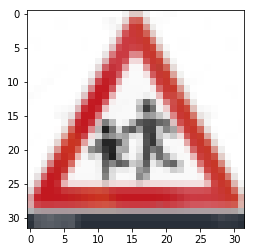

In [45]:
# Load all the images
unsized_60_km = mpimg.imread('./tests/60_km.jpg')
unsized_children_crossing = mpimg.imread('./tests/children_crossing.jpg')
unsized_no_entry = mpimg.imread('./tests/no_entry.jpg')
unsized_no_passing = mpimg.imread('./tests/no_passing.jpg')
unsized_pedestrians = mpimg.imread('./tests/pedestrians.jpg')
unsized_road_work = mpimg.imread('./tests/road_work.jpg')
unsized_roundabout_mandatory = mpimg.imread('./tests/roundabout_mandatory.jpg')
unsized_stop_sign = mpimg.imread('./tests/stop_sign.jpg')

# Resize every image to be passed through the net
resized_60_km = imresize(unsized_60_km,(32,32,3))
resized_children_crossing = imresize(unsized_children_crossing,(32,32,3))
resized_no_entry = imresize(unsized_no_entry,(32,32,3))
resized_no_passing = imresize(unsized_no_passing,(32,32,3))
resized_pedestrians = imresize(unsized_pedestrians,(32,32,3))
resized_road_work = imresize(unsized_road_work,(32,32,3))
resized_roundabout_mandatory = imresize(unsized_roundabout_mandatory,(32,32,3))
resized_stop_sign = imresize(unsized_stop_sign,(32,32,3))

# Visualize the new images
plt.figure()
plt.imshow(resized_children_crossing)

### Predict the Sign Type for Each Image

In [46]:
# Make a list of all the test images
x_internet = []
x_internet.append(resized_60_km)
x_internet.append(resized_children_crossing)
x_internet.append(resized_no_entry)
x_internet.append(resized_no_passing)
x_internet.append(resized_pedestrians)
x_internet.append(resized_road_work)
x_internet.append(resized_roundabout_mandatory)
x_internet.append(resized_stop_sign)

# Make a list of their labels
y_internet = []
y_internet.append([3])
y_internet.append([28])
y_internet.append([17])
y_internet.append([9])
y_internet.append([27])
y_internet.append([25])
y_internet.append([40])
y_internet.append([14])

In [47]:
# Collect the predicitions of the set collected from the internet
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(logits)
    result = sess.run(softmax, feed_dict={x: x_internet, keep_prob:1})
    values, indices = tf.nn.top_k(result, 1)
    probs = sess.run(values)
    predictions = sess.run(indices)

In [48]:
import time

# Collect the predictions of the test set
start_time = time.time()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_softmax = tf.nn.softmax(logits)
    test_result = sess.run(test_softmax, feed_dict={x: X_test, keep_prob:1})
    test_values, test_indices = tf.nn.top_k(test_result, 1)
    test_probs = sess.run(test_values)
    test_predictions = sess.run(test_indices)
    
stop_time = time.time()

elapse_time = stop_time - start_time
average_inference = elapse_time / n_test

print("--- %s seconds ---" % (average_inference))
print("--- %s seconds ---" % (elapse_time))

--- 5.146211229990327e-05 seconds ---
--- 0.6499664783477783 seconds ---


### Analyze Performance on Internet Set

62.5


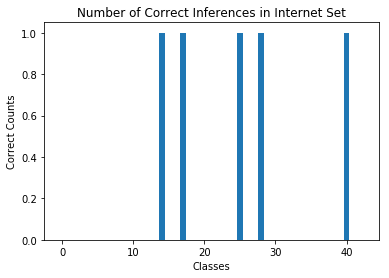

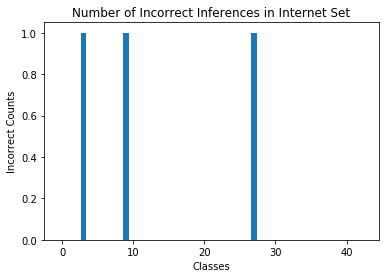

In [65]:
n_internet = len(x_internet)
bins = range(n_classes)
perf = 0
internet_correct = np.zeros((n_classes,1))
internet_wrong = np.zeros((n_classes,1))

for i in range(n_internet):
    int_ind = y_internet[i]
    if predictions[i,0] == int_ind:
        perf += 1
        internet_correct[int_ind] += 1
    else:
        internet_wrong[int_ind] += 1
perf = perf * (100/n_internet)

print(perf)

plt.figure()
plt.bar(bins,internet_correct)
plt.title('Number of Correct Inferences in Internet Set')
plt.xlabel('Classes')
plt.ylabel('Correct Counts')

plt.figure()
plt.bar(bins,internet_wrong)
plt.title('Number of Incorrect Inferences in Internet Set')
plt.xlabel('Classes')
plt.ylabel('Incorrect Counts')

### Analyze Performance on Testing Set

91.6072842438638


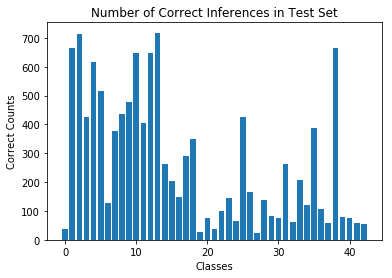

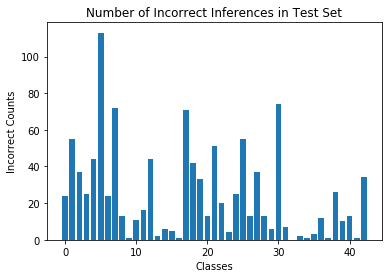

In [64]:
test_perf = 0
test_correct = np.zeros((n_classes,1))
test_wrong = np.zeros((n_classes,1))

for i in range(n_test):
    test_ind = y_test[i]
    if test_predictions[i,0] == test_ind:
        test_perf += 1
        test_correct[test_ind] += 1
    else:
        test_wrong[test_ind] += 1
test_perf = test_perf * (100/n_test)

print(test_perf)

plt.figure()
plt.bar(bins,test_correct)
plt.title('Number of Correct Inferences in Test Set')
plt.xlabel('Classes')
plt.ylabel('Correct Counts')

plt.figure()
plt.bar(bins,test_wrong)
plt.title('Number of Incorrect Inferences in Test Set')
plt.xlabel('Classes')
plt.ylabel('Incorrect Counts')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [51]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax = tf.nn.softmax(logits)
    result = sess.run(softmax, feed_dict={x: x_internet, keep_prob:1})
    values, indices = tf.nn.top_k(result, 5)
    probs = sess.run(values)
    predictions = sess.run(indices)
print(probs)
print(predictions)

[[  4.38517034e-01   2.70886540e-01   2.33679444e-01   2.31562201e-02
    9.83080082e-03]
 [  8.91817629e-01   7.84224123e-02   1.31280795e-02   7.06660748e-03
    3.42625519e-03]
 [  9.57660913e-01   3.96940522e-02   2.64503993e-03   4.40608527e-09
    2.48765952e-10]
 [  9.63278949e-01   1.73954330e-02   8.94766580e-03   3.36593832e-03
    3.34194605e-03]
 [  7.02649176e-01   1.62035242e-01   7.44278878e-02   5.03078401e-02
    2.82443175e-03]
 [  9.45768356e-01   1.97008662e-02   1.24604953e-02   6.93970965e-03
    6.26508519e-03]
 [  4.03842419e-01   2.61225581e-01   1.01885386e-01   7.73026571e-02
    6.36706203e-02]
 [  4.53968793e-01   3.10063481e-01   1.17945023e-01   1.12069353e-01
    2.49078032e-03]]
[[ 1  4  2 13 15]
 [28 20 18 29 23]
 [17 14 12 10 16]
 [38 40 35 34  8]
 [18 25 27 29 31]
 [25 10 30 22 11]
 [40 33 39 35 37]
 [14 17 10 12 13]]


---

## Step 4: Visualize the Neural Network's State with Test Images



In [52]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max)
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max)
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min)
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest")

In [53]:
# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv1_c = conv2d(x, weights['wc1'],biases['bc1'])
# Local Response Normalization
conv1_n = tf.nn.local_response_normalization(conv1_c,5,2.0,0.001,0.75)
# Activation.
conv1_a = activation(conv1_n)
# Pooling. Input = 28x28x6. Output = 14x14x6.
conv1 = maxpool2d(conv1_a)

# Layer 2: Convolutional. Output = 10x10x16.
conv2_c = conv2d(conv1, weights['wc2'],biases['bc2'])    
# Local Response Normalization
conv2_n = tf.nn.local_response_normalization(conv2_c,5,2.0,0.001,0.75)
# Activation.
conv2_a = activation(conv2_n)
# Pooling. Input = 10x10x16. Output = 5x5x16.
conv2 = maxpool2d(conv2_a)

vis_data = []
vis_data.append(X_augmented_train[0])

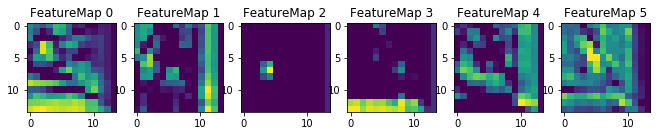

In [54]:
outputFeatureMap(vis_data,conv1)

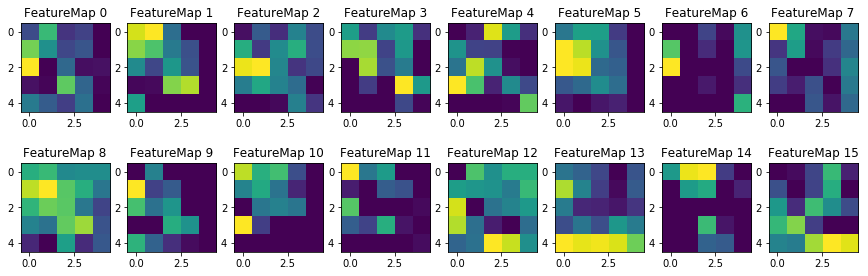

In [55]:
outputFeatureMap(vis_data,conv2)